In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,RobustScaler
from scipy.stats import norm

### 分析数据集
- 检查缺失值
- 检查数据分布
- 填充缺失值

发现age和cabin缺失多

In [29]:
import pandas as pd

# Load the dataset
file_path = r'D:\github_repo_forked\lifetime_value\titanic\train.csv'
data = pd.read_csv(file_path)

# Count missing values in each column
missing_values = data.isnull().sum()

# Display the number of missing values per column
print("Missing values per column:")
print(missing_values)

# Display columns with missing values and their unique values
missing_columns = missing_values[missing_values > 0].index
for col in missing_columns:
    print(f"\nColumn '{col}' has {missing_values[col]} missing values.")
    print(f"Unique values and their counts in '{col}':")
    print(data[col].value_counts(dropna=True))

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Column 'Age' has 177 missing values.
Unique values and their counts in 'Age':
Age
24.00    30
22.00    27
18.00    26
28.00    25
30.00    25
         ..
24.50     1
0.67      1
0.42      1
34.50     1
74.00     1
Name: count, Length: 88, dtype: int64

Column 'Cabin' has 687 missing values.
Unique values and their counts in 'Cabin':
Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Column 'Embarked' has 2 missing values.
Unique values and their counts in 'Embarked':
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


检查age分布

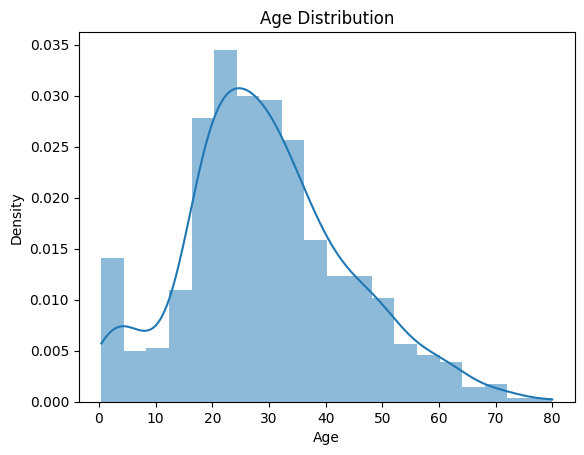

Statistics=0.9814577414504954, p=7.337348958673592e-08
Age does not follow a normal distribution (reject H0)


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the dataset
file_path = r'D:\github_repo_forked\lifetime_value\titanic\train.csv'
data = pd.read_csv(file_path)

# Plot distribution of Age
sns.histplot(data['Age'].dropna(), kde=True, stat="density", linewidth=0)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

# Optionally, perform a normality test
from scipy.stats import shapiro
stat, p = shapiro(data['Age'].dropna())
print(f'Statistics={stat}, p={p}')
if p > 0.05:
    print('Age follows a normal distribution (fail to reject H0)')
else:
    print('Age does not follow a normal distribution (reject H0)')

用mean填补age空值

In [34]:
# Fill missing Age values with the mean (or median)
age_mean = data['Age'].mean()
data['Age'] = data['Age'].fillna(age_mean)

# Verify the filling
print(data['Age'].isnull().sum())  # Should print 0

0


检查cabin分布

Unique values and their counts in 'Cabin':
Cabin_First_Letter
NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: count, dtype: int64


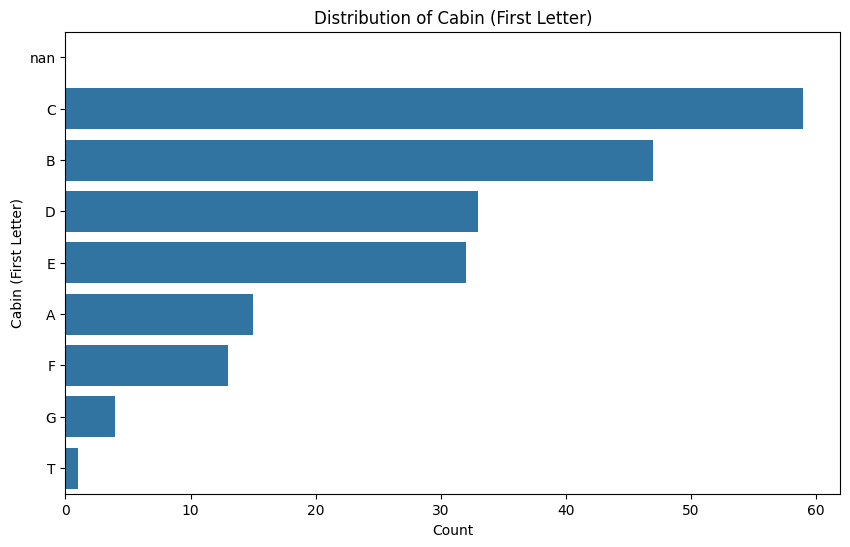

Total records: 891
Missing 'Cabin' values: 687
Unique 'Cabin' values: 8


In [39]:
# Check unique values and their counts
data['Cabin_First_Letter'] = data['Cabin'].str[0]
cabin_counts = data['Cabin_First_Letter'].value_counts(dropna=False)
print("Unique values and their counts in 'Cabin':")
print(cabin_counts)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of Cabin_First_Letter
plt.figure(figsize=(10, 6))
sns.countplot(y='Cabin_First_Letter', data=data, order=cabin_counts.index)
plt.title('Distribution of Cabin (First Letter)')
plt.xlabel('Count')
plt.ylabel('Cabin (First Letter)')
plt.show()

# Summarize the distribution
total_cabins = len(data)
missing_cabins = data['Cabin'].isnull().sum()
unique_cabins = data['Cabin_First_Letter'].nunique()

print(f"Total records: {total_cabins}")
print(f"Missing 'Cabin' values: {missing_cabins}")
print(f"Unique 'Cabin' values: {unique_cabins}")

用正态分布填充

0


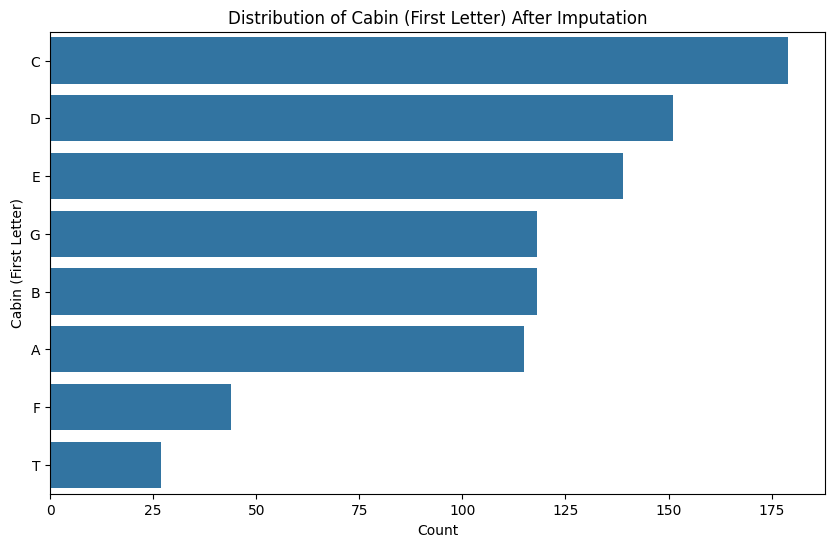

In [ ]:


# Convert letters to numerical values
letter_mapping = {letter: idx for idx, letter in enumerate(data['Cabin_First_Letter'].dropna().unique())}
data['Cabin_First_Letter_Num'] = data['Cabin_First_Letter'].map(letter_mapping)

# Calculate the mean and standard deviation of the existing distribution
existing_letters = data['Cabin_First_Letter_Num'].dropna()
mean = existing_letters.mean()
std = existing_letters.std()

# Generate a normal distribution based on the mean and std
normal_dist = norm(loc=mean, scale=std)

# Impute missing values to match the normal distribution
missing_count = data['Cabin_First_Letter_Num'].isnull().sum()
imputed_values = normal_dist.rvs(size=missing_count).round().astype(int)

# Ensure imputed values are within the range of existing categories
imputed_values = np.clip(imputed_values, existing_letters.min(), existing_letters.max())

# Map numerical values back to letters
reverse_letter_mapping = {v: k for k, v in letter_mapping.items()}
imputed_letters = [reverse_letter_mapping[val] for val in imputed_values]

# Fill missing values
data.loc[data['Cabin_First_Letter_Num'].isnull(), 'Cabin_First_Letter'] = imputed_letters

# Verify the filling
print(data['Cabin_First_Letter'].isnull().sum())  # Should print 0

# Plot the new distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='Cabin_First_Letter', data=data, order=data['Cabin_First_Letter'].value_counts().index)
plt.title('Distribution of Cabin (First Letter) After Imputation')
plt.xlabel('Count')
plt.ylabel('Cabin (First Letter)')
plt.show()

In [11]:
def fill_missing_cabin_letters(df):
    df['Cabin_First_Letter'] = df['Cabin'].str[0]
    # Convert letters to numerical values
    letter_mapping = {letter: idx for idx, letter in enumerate(df['Cabin_First_Letter'].dropna().unique())}
    df['Cabin_First_Letter_Num'] = df['Cabin_First_Letter'].map(letter_mapping)

    # Calculate the mean and standard deviation of the existing distribution
    existing_letters = df['Cabin_First_Letter_Num'].dropna()
    mean = existing_letters.mean()
    std = existing_letters.std()

    # Generate a normal distribution based on the mean and std
    normal_dist = norm(loc=mean, scale=std)

    # Impute missing values to match the normal distribution
    missing_count = df['Cabin_First_Letter_Num'].isnull().sum()
    imputed_values = normal_dist.rvs(size=missing_count).round().astype(int)

    # Ensure imputed values are within the range of existing categories
    imputed_values = np.clip(imputed_values, existing_letters.min(), existing_letters.max())

    # Map numerical values back to letters
    reverse_letter_mapping = {v: k for k, v in letter_mapping.items()}
    imputed_letters = [reverse_letter_mapping[val] for val in imputed_values]

    # Fill missing values
    df.loc[df['Cabin_First_Letter_Num'].isnull(), 'Cabin_First_Letter'] = imputed_letters

In [21]:
def preprocess_features(df):
    df_processed = df.copy()

    # 填充age
    age_mean = df_processed['Age'].mean()
    df_processed['Age'] = df_processed['Age'].fillna(age_mean)
    
    # 填充Cabin_First_Letter
    fill_missing_cabin_letters(df_processed)

    # 1. Binary encoding
    df_processed['Sex'] = (df_processed['Sex'] == 'male').astype(int)
    
    df_processed['Pclass'] = df_processed['Pclass'].astype(int)


    # 2. One-hot encoding for low cardinality
    low_card_features = ['Embarked']
    df_processed = pd.get_dummies(df_processed, 
                                columns=low_card_features, 
                                drop_first=True)
    
    # 3. Label encoding for high cardinality (for embedding)
    high_card_features = ['Ticket','Cabin_First_Letter']
    for feat in high_card_features:
        le = LabelEncoder()
        df_processed[feat] = df_processed[feat].astype(str)
        df_processed[feat] = le.fit_transform(df_processed[feat].fillna('0'))
    
    # 4. Normalize numeric features
    age_scaler = StandardScaler()
    df_processed['Age'] = age_scaler.fit_transform(df_processed['Age'].values.reshape(-1, 1))
    
    for feat in ['SibSp', 'Parch','Fare']:
        feature_scaler = StandardScaler()
        log_transformed = np.log1p(df_processed[feat].values)
        df_processed[feat] = feature_scaler.fit_transform(log_transformed.reshape(-1, 1))
    
    return df_processed

In [3]:
CATEGORICAL_FEATURES = [
    'Ticket',
]
BINARY_FEATURES = [
    'Sex',
]
LOW_CARD_FEATURES = [
    'Cabin_First_Letter', 
    'Embarked'
]
NUMERIC_FEATURES = [
    'Age',
    'SibSp',
    'Parch',
    'Fare'
]

In [ ]:
def xgboost_split(df):
    df_processd = preprocess_features(df)
    x = df_processd.drop(columns=['PassengerId', 'Name', 'Survived','Cabin_First_Letter_Num','Cabin','Cabin_First_Letter'])
    y = df_processd['Survived']
    x_train, x_eval, y_train, y_eval = train_test_split(
        x, y, test_size=0.2, random_state=123,stratify=y)

    return x_train, x_eval, y_train, y_eval

In [6]:
def xgboost_model():
    return XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='aucpr',
        n_estimators=100,
        n_jobs=-1,
        verbosity=1,
        random_state=123,
        early_stopping_round=10
    )

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def analyze_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Class 0', 'Class 1'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()
    print("Confusion Matrix Analysis:")
    print(f"True Negatives (TN): {tn}")  # 正确预测为负类
    print(f"False Positives (FP): {fp}") # 错误预测为正类
    print(f"False Negatives (FN): {fn}") # 错误预测为负类
    print(f"True Positives (TP): {tp}")  # 正确预测为正类
    print("\nKey Metrics:")
    print(f"Accuracy: {accuracy:.4f}")   # 整体准确率
    print(f"Precision: {precision:.4f}") # 正类预测准确率
    print(f"Recall: {recall:.4f}")      # 正类预测召回率
    print(f"F1-score: {f1:.4f}")        # precision和recall的调和平均

def plot_roc_auc(y_true, y_pred_proba):
    # Get predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [46]:
file = r'D:\github_repo_forked\lifetime_value\titanic\train.csv'
df = pd.read_csv(file)

In [45]:
df.shape[0]

418

In [22]:
df_processd = preprocess_features(df)


In [23]:
df_processd.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabin_First_Letter,Cabin_First_Letter_Num,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.592481,0.889164,-0.52906,523,-0.879741,NaN,2,NaN,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.638789,0.889164,-0.52906,596,1.361220,C85,2,0.0,False,False
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.284663,-0.609279,-0.52906,669,-0.798540,NaN,0,NaN,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.407926,0.889164,-0.52906,49,1.062038,C123,2,0.0,False,True
4,5,0,3,"Allen, Mr. William Henry",1,0.407926,-0.609279,-0.52906,472,-0.784179,NaN,3,NaN,False,True


In [24]:
x_train,x_eval,y_train,y_eval = xgboost_split(df)

In [25]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S
222,3,1,1.639196,-0.609279,-0.529060,102,-0.784179,False,True
610,3,0,0.715743,0.889164,3.825691,333,0.528699,False,True
249,2,1,1.870059,0.889164,-0.529060,144,0.344439,False,True
814,3,1,0.061631,-0.609279,-0.529060,427,-0.784179,False,True
118,1,1,-0.438572,-0.609279,1.155587,585,2.636313,False,False


In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0.1, 0.5, 1.0],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [0.1, 0.5, 1,1.5]
}
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='aucpr',
                            device='cuda'

),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=5
)
optimal_params.fit(x_train,
                   y_train,
                   eval_set=[(x_eval, y_eval)],
                   verbose=False)
print(optimal_params.best_params_)   

{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'reg_lambda': 1, 'scale_pos_weight': 1.5}


In [36]:
optimal_xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_lambda=1,
    # min_child_weight = 5,  # 增加最小子节点权重
    objective='binary:logistic',
    scale_pos_weight=1,
    seed=42,
    eval_metric='aucpr',
    early_stopping_rounds=10
)
# {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 1, 'scale_pos_weight': 1} auc=0.83



[0]	validation_0-aucpr:0.79539
[1]	validation_0-aucpr:0.77404
[2]	validation_0-aucpr:0.75524
[3]	validation_0-aucpr:0.80405
[4]	validation_0-aucpr:0.82175
[5]	validation_0-aucpr:0.83905
[6]	validation_0-aucpr:0.84415
[7]	validation_0-aucpr:0.84932


[8]	validation_0-aucpr:0.84888
[9]	validation_0-aucpr:0.85534
[10]	validation_0-aucpr:0.84827
[11]	validation_0-aucpr:0.85390
[12]	validation_0-aucpr:0.85164
[13]	validation_0-aucpr:0.86181
[14]	validation_0-aucpr:0.85793
[15]	validation_0-aucpr:0.85518
[16]	validation_0-aucpr:0.84920
[17]	validation_0-aucpr:0.84996
[18]	validation_0-aucpr:0.84711
[19]	validation_0-aucpr:0.85216
[20]	validation_0-aucpr:0.85673
[21]	validation_0-aucpr:0.85612
[22]	validation_0-aucpr:0.85309


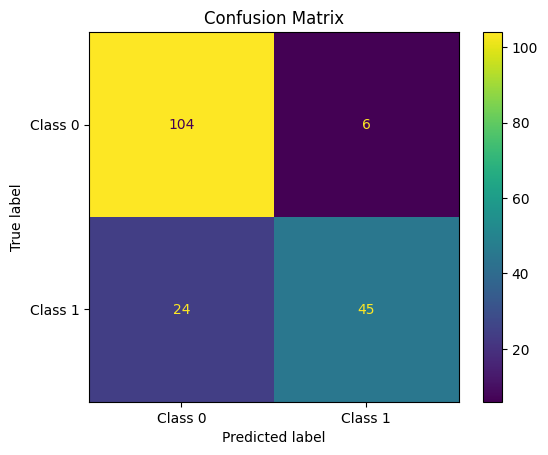

Confusion Matrix Analysis:
True Negatives (TN): 104
False Positives (FP): 6
False Negatives (FN): 24
True Positives (TP): 45

Key Metrics:
Accuracy: 0.8324
Precision: 0.8824
Recall: 0.6522
F1-score: 0.7500


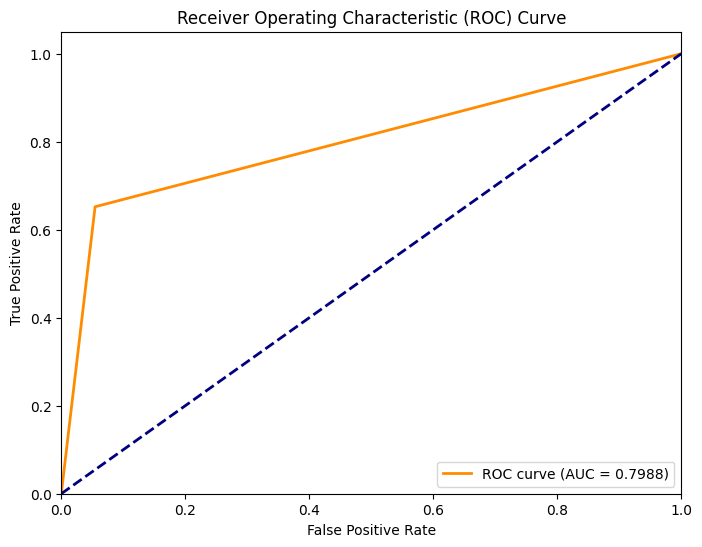

np.float64(0.7988142292490119)

In [37]:
optimal_xgb.fit(x_train, y_train, verbose=True,  eval_set=[(x_eval, y_eval)])
y_pred = optimal_xgb.predict(x_eval)
analyze_confusion_matrix(y_eval, y_pred)
plot_roc_auc(y_eval, y_pred)

In [41]:
import pandas as pd
import xgboost as xgb

# Load and preprocess test data
test_file = r'D:\github_repo_forked\lifetime_value\titanic\test.csv'
test_data = pd.read_csv(test_file)
test_df = preprocess_features(test_data)
# test_df['Embarked_C'] = False
x_test = test_df.drop(columns=['PassengerId', 'Name','Cabin','Cabin_First_Letter_Num','Cabin_First_Letter'])

# Function to predict and save results
def predict_and_save(model, test_df, output_file):

    predictions = model.predict(x_test)
    predictions = (predictions >= 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Create DataFrame with PassengerId and Survived
    results_df = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': predictions
    })
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)

# Usage
output_file = 'age_mean_xgboost_test_predictions.csv'
predict_and_save(optimal_xgb, test_df, output_file)
print(f"Predictions saved to {output_file}")

Predictions saved to age_mean_xgboost_test_predictions.csv
